In [33]:
"""IMPORTING ALL REQUIRED MODULES"""
import os
import numpy as np
import tensorflow as tf
from tensorflow.python.platform import gfile
import cv2
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
def extract_face(filename, required_size=(160, 160)):
    # load image from file
    image = cv2.imread(filename)#Read image file
    
    """
       Detecting face boundaries using Haar feature-based cascade classifiers wich an effective
       object detection method proposed by Paul Viola and Michael Jones in their paper,
       “Rapid Object Detection using a Boosted Cascade of Simple Features” in 2001.
    """
    
    face_det=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    faces = face_det.detectMultiScale(image, 1.3, 5)#detect faces
    
    if list(faces):#If face is detected
            # extract the bounding box from the first face
            x1, y1, width, height = faces[0]
            x1, y1= abs(x1), abs(y1)
            x2, y2= x1 + width, y1 + height
            face=image[y1:y2, x1:x2]#extracting face
            face_array=cv2.resize(face,required_size)
            return face_array
    else:
        #print('Face Not Detected')
        return []

In [3]:
def load_faces(directory):
    """Function to get get image vector of faces and add them in list """
    faces = list()
    # enumerate files
    for filename in os.listdir(directory):
        path = directory + filename
        # get face
        face = extract_face(path)
        if list(face):
            faces.append(face)
    return faces

In [4]:
def load_dataset(directory):
    X, y = list(), list()#declaring empty lists
    for celebrities in os.listdir(directory):
        path = directory + celebrities + '/'
        # load all faces of celebrities
        faces = load_faces(path)
        # create labels
        labels = [celebrities for _ in range(len(faces))]
        # summarize progress
        print('>loaded %d examples for class: %s' % (len(faces), celebrities))
        # store
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)

In [5]:
"""Creating Training and Testing set"""
print("Training Set")
x_train,y_train=load_dataset('5-celebrity-faces-dataset(modified)/train/')
print("Validation Set")
x_val,y_val=load_dataset('5-celebrity-faces-dataset(modified)/val/')

Training Set
>loaded 11 examples for class: ben_afflek
>loaded 12 examples for class: madonna
>loaded 7 examples for class: me
>loaded 10 examples for class: elton_john
>loaded 20 examples for class: mindy_kaling
>loaded 21 examples for class: jerry_seinfeld
Validation Set
>loaded 6 examples for class: ben_afflek
>loaded 6 examples for class: madonna
>loaded 5 examples for class: me
>loaded 5 examples for class: elton_john
>loaded 6 examples for class: mindy_kaling
>loaded 6 examples for class: jerry_seinfeld


In [6]:
"""Encoding y labels to be used in model """
from sklearn.preprocessing import LabelEncoder
y_train=LabelEncoder().fit_transform(y_train.ravel())
y_val=LabelEncoder().fit_transform(y_val.ravel())

In [7]:
y_val

array([0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1,
       5, 5, 5, 5, 5, 5, 2, 2, 2, 2, 2, 2])

In [8]:
def get_batch(x,y):
    """Create batch for training and validation"""
    batch_size=32 #size
    n_examples=x.shape[0]#limit for extracting random images and labels
    #Intilize batch data
    label_batch=np.zeros((batch_size,))
    image_batch=np.zeros((batch_size,160,160,3))
    
    #varible used for getting random images and labels
    idx_1=np.random.choice(n_examples,batch_size,replace=False)
    
    #loop for creating batches
    for i in range(batch_size):
        image_batch[i,:,:,:]=x[idx_1[i]]
        label_batch[i]=y[idx_1[i]]
    im=tf.cast(image_batch,tf.float32)
    return im,label_batch

In [25]:
train=get_batch(x_train,y_train)
val=get_batch(x_val,y_val)

In [26]:
train

(<tf.Tensor 'Cast_6:0' shape=(32, 160, 160, 3) dtype=float32>,
 array([1., 2., 2., 5., 5., 5., 3., 2., 2., 2., 0., 5., 2., 2., 3., 0., 2.,
        1., 0., 5., 5., 1., 1., 4., 2., 2., 4., 2., 2., 5., 3., 5.]))

In [27]:
#creating the Model
IMG_SHAPE=(160,160,3)#Same to our image shape

"""The MobileNetV2 architecture is based on an inverted residual structure where the input and output of the 
   residual block are thin bottleneck layers opposite to traditional residual models which use expanded 
   representations in the input an MobileNetV2 uses lightweight depthwise convolutions to filter features in 
   the intermediate expansion layer.
"""
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
#We freeze all the trainble weights 
base_model.trainable = False 
base_model.summary()#Descirbe the architecture of the MobileNetV2

feature_batch = base_model(train)
print(feature_batch.shape)#Extracted faeture shape 

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

(32, 5, 5, 1280)


In [28]:
#Adding our classification layer

#Pooling Layer
global_average_layer=tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average=global_average_layer(feature_batch)
print(feature_batch_average.shape)
#Prediction Layer
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

#addind our layer on top base_model
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer])

base_learning_rate = 0.0001
#Compile Model
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()#Our model description

(32, 1280)
(32, 1)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [29]:
#Training
initial_epochs =15
history = model.fit(train,epochs=initial_epochs,steps_per_epoch=5)

Epoch 1/15
5/5 [==============================] - 14s 3s/step - loss: 9.3241 - acc: 0.1937
Epoch 2/15
5/5 [==============================] - 8s 2s/step - loss: 2.9979 - acc: 0.4625
Epoch 3/15
5/5 [==============================] - 8s 2s/step - loss: 0.5171 - acc: 0.6875
Epoch 4/15
5/5 [==============================] - 8s 2s/step - loss: 0.3507 - acc: 0.7437
Epoch 5/15
5/5 [==============================] - 8s 2s/step - loss: 0.2787 - acc: 0.8562
Epoch 6/15
5/5 [==============================] - 8s 2s/step - loss: 0.2174 - acc: 0.8875
Epoch 7/15
5/5 [==============================] - 8s 2s/step - loss: 0.1688 - acc: 0.9250
Epoch 8/15
5/5 [==============================] - 8s 2s/step - loss: 0.1269 - acc: 0.9563
Epoch 9/15
5/5 [==============================] - 8s 2s/step - loss: 0.0903 - acc: 1.0000
Epoch 10/15
5/5 [==============================] - 9s 2s/step - loss: 0.0602 - acc: 1.0000
Epoch 11/15
5/5 [==============================] - 8s 2s/step - loss: 0.0409 - acc: 1.0000
Epoch 1

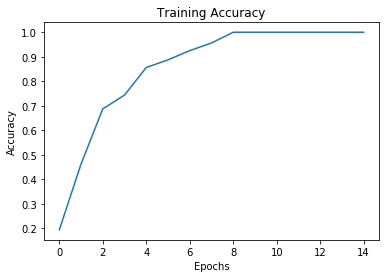

In [34]:
acc = history.history['acc']
loss = history.history['loss']


plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(acc, label='Training Accuracy')#plotting accuracy



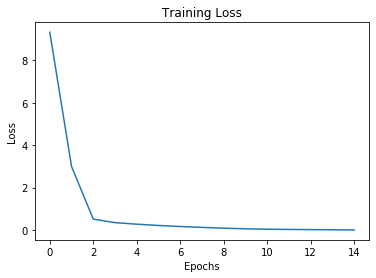

In [35]:
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, label='Training Loss') #plotting loss

In [32]:
#Testing data on validation set gave us accuracy of 86%

model.test_on_batch(val[0], y=val[1], sample_weight=None, reset_metrics=True)

[-20.745548, 0.8645833]